In [1]:
%load_ext autoreload
%autoreload 2
import gc
from glob import glob
import os
from pathlib import Path
import re
import sys
import yaml
import datetime
import numpy as np
import pandas as pd
from tqdm import tqdm
from func.utils import timer, get_categorical_features, read_pkl_gzip, to_pkl_gzip, parallel_load_data, get_filename, logger_func
from ieee_train import eval_train, eval_check_feature
from kaggle_utils import reduce_mem_usage, move_feature
from func.ml_utils import display_importance

import lightgbm as lgb
from sklearn.metrics import roc_auc_score, mean_squared_error
import shutil

try:
    logger
except NameError:
    logger = logger_func()
    
save_file_path = '../output/valid_single_feature.csv'

2019-09-19 22:54:36,869 func.utils 347 [INFO]    [logger_func] start 


In [2]:
COLUMN_ID = 'TransactionID'
COLUMN_DT = 'TransactionDT'
COLUMN_TARGET = 'isFraud'
COLUMN_GROUP = 'DT-M'
COLUMNS_IGNORE = [COLUMN_ID, COLUMN_DT, COLUMN_TARGET, COLUMN_GROUP, 'is_train', 'date']


def make_dataset(is_train):
    
    if is_train:
        # paths_train = glob('../submit/sub_valid/*_train.gz')
        paths_train = glob('../feature/raw_use/*_train.gz')
        paths_train += sorted(glob('../feature/org_use/*_train.gz'))
#         paths_train += sorted(glob('../feature/valid_use/*_train.gz'))
        # paths_train += sorted(glob('../submit/lb9516/*_train.gz'))
        
        # paths_train += glob('../feature/create/524__fill*_train.gz')
        # paths_train += glob('../feature/create/524__bin*_train.gz')
        
        df = parallel_load_data(paths_train)
    
    else:
        # paths_test = glob('../submit/sub_valid/*_test.gz')
        paths_test = glob('../feature/raw_use/*_test.gz')
        paths_test += sorted(glob('../feature/org_use/*_test.gz'))
#         paths_test += sorted(glob('../feature/valid_use/*_test.gz'))
        # paths_test += sorted(glob('../submit/lb9516/*_test.gz'))
        
        # paths_test += glob('../feature/create/524__fill*_test.gz')
        # paths_test += glob('../feature/create/524__bin*_test.gz')
        
        df = parallel_load_data(paths_test)
    return df

df_train = make_dataset(True)
df_test = make_dataset(False)

group_kfold_path = '../input/0908_ieee__DT-M_GroupKFold.gz'
group = read_pkl_gzip(group_kfold_path)
df_train[COLUMN_GROUP] = group


def down_sampling(df, drop_12=False):

    #========================================================================
    # Cut 2017-12
    #========================================================================
    if drop_12:
        df = df[df[COLUMN_GROUP]!='2017-12']

    #========================================================================
    # Negative Down Sampling
    #========================================================================
    frac = 0.2
    seed = 1208
    np.random.seed(seed)
    df_pos = df[df.isFraud==1]
    df_neg = df[df.isFraud!=1]
    del df
    gc.collect()
    print(df_pos.shape, df_neg.shape)
    df_neg = df_neg.sample(int(df_neg.shape[0] * frac))
    df = pd.concat([df_pos, df_neg], axis=0)
    print(df.shape)
    
    return df


#========================================================================
# bear
#========================================================================
bear = pd.read_csv('../input/20190913_ieee__bear_probing.csv').iloc[:, [0, 3, 4, 6]]
bear = bear[bear[COLUMN_TARGET]==-1]
bear = bear.iloc[:, [0,1,3]]
bear.columns = [COLUMN_ID, 'data_type', COLUMN_TARGET]
submission = pd.read_csv('../input/sample_submission.csv')
submission.columns = [COLUMN_ID, 'pred']

    
def valid_submit_prediction(prediction):
    """Summary line.
    他Submit Prediction Valueとの相関をチェック
    Args:
    
    Returns:
    """
    list_submit_path = sorted(glob('../submit/validation/*.csv'))
    list_submit = []
    
    print("* Check Corr with Past Submit.")
    for path in list_submit_path:
        lb_score = re.search(rf'([^/LB]*).csv', path).group(1)
        submit = pd.read_csv(path)[COLUMN_TARGET].values
        
        print('  * ', prediction.shape, submit.shape)
        corr = np.min(np.corrcoef(prediction, submit))
        print(f"  * LB{lb_score} / {corr}")

        
def bear_validation(test_pred):
    submission['pred'] = test_pred
    bear_score = submission.merge(bear, how='inner', on=COLUMN_ID)
    public  = bear_score[bear_score['data_type']=='test_public']
    private = bear_score[bear_score['data_type']=='test_private']
    
    public_score = roc_auc_score(public[COLUMN_TARGET].values, public['pred'].values)
    private_score = roc_auc_score(private[COLUMN_TARGET].values, private['pred'].values)
    all_score = roc_auc_score(bear_score[COLUMN_TARGET].values, bear_score['pred'].values)

    return public_score, private_score, all_score

Process ForkPoolWorker-40:
Process ForkPoolWorker-59:
Process ForkPoolWorker-111:
Process ForkPoolWorker-5:
Process ForkPoolWorker-85:
Process ForkPoolWorker-78:
Process ForkPoolWorker-164:
Process ForkPoolWorker-42:
Process ForkPoolWorker-68:
Process ForkPoolWorker-48:
Process ForkPoolWorker-90:
Process ForkPoolWorker-117:
Process ForkPoolWorker-129:
Process ForkPoolWorker-160:
Process ForkPoolWorker-161:
Process ForkPoolWorker-58:
Process ForkPoolWorker-144:
Process ForkPoolWorker-89:
Process ForkPoolWorker-66:
Process ForkPoolWorker-88:
Process ForkPoolWorker-168:
Process ForkPoolWorker-34:
Process ForkPoolWorker-29:
Process ForkPoolWorker-43:
Process ForkPoolWorker-98:
Process ForkPoolWorker-159:
Process ForkPoolWorker-128:
Process ForkPoolWorker-157:
Process ForkPoolWorker-101:
Process ForkPoolWorker-148:
Process ForkPoolWorker-126:
Process ForkPoolWorker-131:
Process ForkPoolWorker-15:
Process ForkPoolWorker-63:
Process ForkPoolWorker-57:
Process ForkPoolWorker-116:
Process ForkP

In [4]:
# Best Model
df_pred = read_pkl_gzip('../output/pred_result/20190917_0022__CV0-9476767369741764__all_preds.gz')
df_pred.columns = [COLUMN_ID, 'pred']


# 8th Validation
eight = pd.read_csv('../input/train_last100k_prediction.csv')
eight.columns = [COLUMN_ID, COLUMN_TARGET, 'eight']
col_eight = 'eight'

eight_ids = eight[COLUMN_ID].values
df_pred = df_pred[df_pred[COLUMN_ID].isin(eight_ids)]
df_pred.reset_index(drop=True, inplace=True)
df_pred['_pred_rank'] = df_pred['pred'].rank()
eight['_eight_rank'] = eight['eight'].rank()

df_pred.sort_values(by=COLUMN_ID, inplace=True)
eight.sort_values(by=COLUMN_ID, inplace=True)

tmp = df_pred.merge(eight, how='inner', on=COLUMN_ID)
print('eight score:', roc_auc_score(tmp[COLUMN_TARGET], tmp['_eight_rank']))
print('my score:', roc_auc_score(tmp[COLUMN_TARGET], tmp['_pred_rank']))
del tmp[COLUMN_TARGET]

# Residual Target

tmp['residual'] = tmp['_pred_rank'] - tmp['_eight_rank']

df_train = df_train.merge(tmp, how='inner', on=COLUMN_ID)
print(df_train.shape)

COLUMN_RES = 'residual'
COLUMNS_IGNORE = [COLUMN_ID, COLUMN_DT, COLUMN_TARGET, COLUMN_GROUP, 'is_train', 'date', COLUMN_RES, 'eight', '_eight_rank', 'pred', '_pred_rank']

Y = df_train[COLUMN_RES]

(100000, 208)


In [5]:
df_user_id_bear = pd.read_csv('../output/same_user_pattern/20190901_user_ids_share.csv').set_index(COLUMN_ID)
df_train.set_index(COLUMN_ID, inplace=True)
df_train['user_id_bear'] = df_user_id_bear['predicted_user_id']

df_test.set_index(COLUMN_ID, inplace=True)
df_test['user_id_bear'] = df_user_id_bear['predicted_user_id']

df_train.reset_index(inplace=True)
df_test.reset_index(inplace=True)

Train Shape: (100000, 201)
[  * Make Dataset] done in 0 s
Training until validation scores don't improve for 20 rounds.
[200]	valid_0's rmse: 14106.6
[400]	valid_0's rmse: 14003.7
Did not meet early stopping. Best iteration is:
[496]	valid_0's rmse: 13976.4


2019-09-19 22:57:46,069 func.utils 115 [INFO]    [<module>]   * base Fold0:13976.40996421127 


[  * Train & Validation] done in 30 s
[  * Make Dataset] done in 0 s
Training until validation scores don't improve for 20 rounds.
[200]	valid_0's rmse: 11705.4
[400]	valid_0's rmse: 11569.4


2019-09-19 22:58:06,864 func.utils 115 [INFO]    [<module>]   * base Fold1:11548.884065319775 


Early stopping, best iteration is:
[465]	valid_0's rmse: 11548.9
[  * Train & Validation] done in 21 s
[  * Make Dataset] done in 0 s
Training until validation scores don't improve for 20 rounds.
[200]	valid_0's rmse: 11106.9
[400]	valid_0's rmse: 10915.6
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 10879.9


2019-09-19 22:58:28,425 func.utils 115 [INFO]    [<module>]   * base Fold2:10879.933779033954 


[  * Train & Validation] done in 21 s
[  * Make Dataset] done in 0 s
Training until validation scores don't improve for 20 rounds.
[200]	valid_0's rmse: 10793.2
[400]	valid_0's rmse: 10582.9


2019-09-19 22:58:49,916 func.utils 115 [INFO]    [<module>]   * base Fold3:10552.368790970277 


Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 10552.4
[  * Train & Validation] done in 21 s
[  * Make Dataset] done in 0 s
Training until validation scores don't improve for 20 rounds.
[200]	valid_0's rmse: 12973.4
[400]	valid_0's rmse: 12816.5
Early stopping, best iteration is:
[420]	valid_0's rmse: 12802.3


2019-09-19 22:59:08,480 func.utils 115 [INFO]    [<module>]   * base Fold4:12802.309770922946 


[  * Train & Validation] done in 18 s


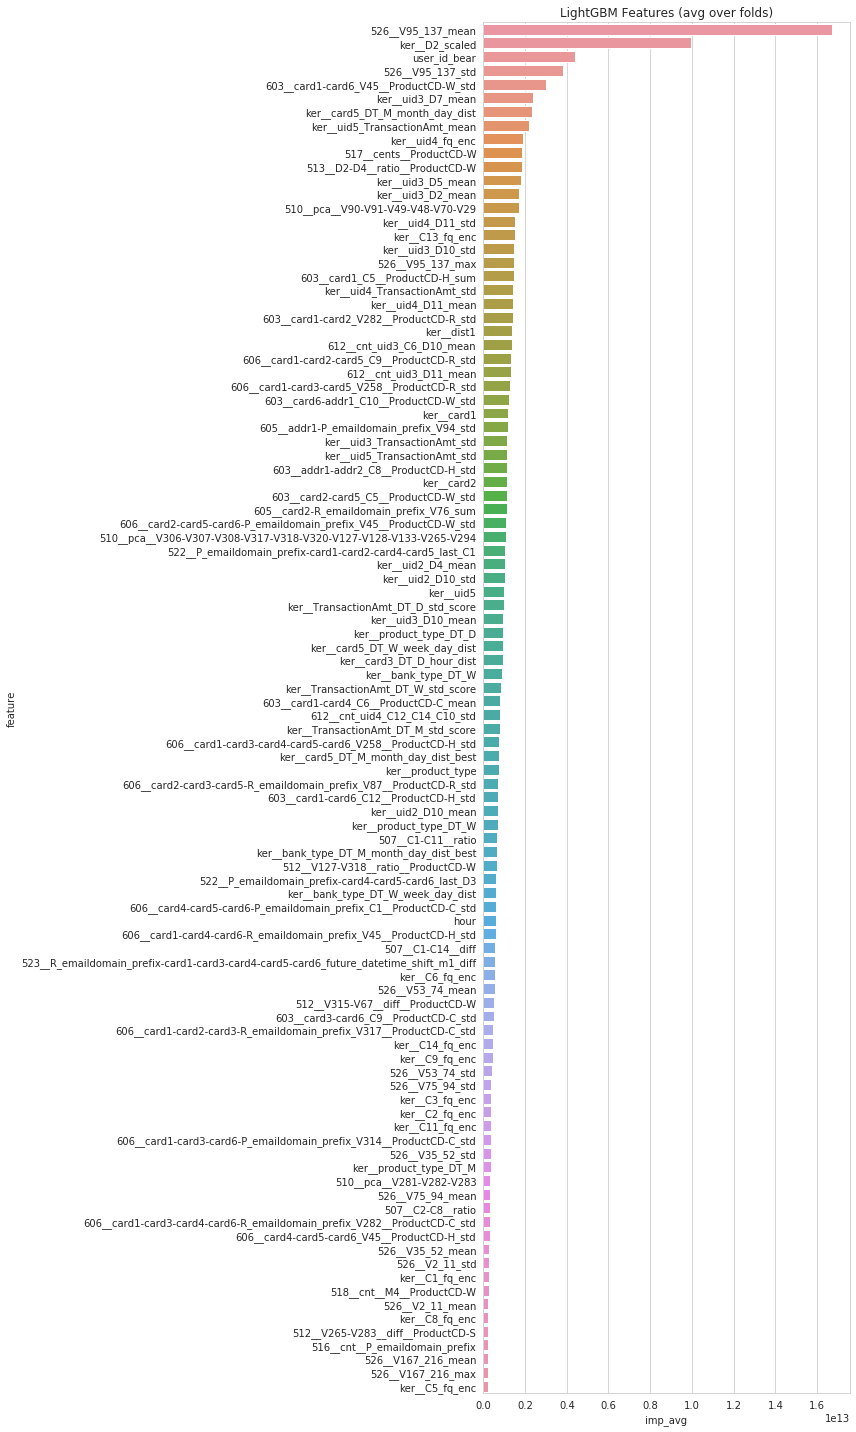

In [8]:
#========================================================================
# Base Featureに検証用Feature Groupを追加して、スコアの変化を見る.
# Baseより向上したFeature Groupのみ、追加検証を行う
#========================================================================
from sklearn.model_selection import KFold

def get_tree_importance(estimator, use_cols, importance_type="gain"):
    feim = estimator.feature_importance(importance_type=importance_type)
    feim = pd.DataFrame([np.array(use_cols), feim]).T
    feim.columns = ['feature', 'importance']
    feim['importance'] = feim['importance'].astype('float32')
    return feim

n_splits = 5
seed = 1208
kfold = KFold(n_splits=n_splits, random_state=seed)
kfold = list(kfold.split(df_train, Y))

# 最初はbaseをTrueにして
start_time = "{0:%Y%m%d_%H%M%S}".format(datetime.datetime.now())[:14]
is_base = [True, False][0]
is_result = [True, False][0]
is_write  = [True, False][1]
to_dir = '../feature/check_trush/'

start_time = "{0:%Y%m%d_%H%M%S}".format(datetime.datetime.now())[:13]
params = {
    'n_jobs': 92,
#             'n_jobs': 40,
#             'n_jobs': 30,
#             'n_jobs': 16,
#             'metric': 'auc',
#             'objective': 'binary',
    'metric': 'rmse',
    'objective': 'regression',
#             'num_leaves': 2**7-1,
    'num_leaves': 2**8-1,
    'max_depth': -1,
    'subsample': 0.9,
    'subsample_freq': 1,
    'colsample_bytree' : 1.0,
    'lambda_l1' : 0.1,
    'lambda_l2' : 1.0,
    'learning_rate' : 0.1,
    "seed": 1208,
    "bagging_seed": 1208,
    "feature_fraction_seed": 1208,
    "drop_seed": 1208,
}


# valid_paths_train = sorted(glob('../feature/valid/*_train.gz'))
valid_paths_train = sorted(glob('../feature/valid_use/*_train.gz'))
loop_no = len(valid_paths_train)
if len(valid_paths_train)==0 and (is_base or is_result):
    loop_no = 1
loop_no = 1
    
for i in range(loop_no):
    
    if is_result:
        valid_path = valid_paths_train
    else:
        valid_path = valid_paths_train[i:i+1]
        
    
    if is_base or len(valid_path)==0:
        tmp_train = df_train.copy()
        feature_name = 'base'
    else:
        df_feat_train = parallel_load_data(valid_path)
        tmp_train = df_train.join(df_feat_train)
        feature_name = get_filename(valid_path[0])
    
    use_cols = [col for col in tmp_train.columns if col not in COLUMNS_IGNORE]
    print('Train Shape:' , tmp_train[use_cols].shape)
    
    x_test = df_test[use_cols]
    feim_list = []
    model_list = []
        
    for n_fold, (trn_idx, val_idx) in enumerate(kfold):
        
        with timer('  * Make Dataset'):

            x_train = tmp_train.loc[trn_idx][use_cols]
            y_train = Y.loc[trn_idx]
            x_valid = tmp_train.loc[val_idx][use_cols]
            y_valid = Y.loc[val_idx]
            early_stopping_rounds=20
            num_boost_round=500
            
            #========================================================================
            # Fitting
            #========================================================================
            lgb_train = lgb.Dataset(data=x_train, label=y_train)
            lgb_valid = lgb.Dataset(data=x_valid, label=y_valid)
        
        with timer("  * Train & Validation"):
            estimator = lgb.train(
                params = params,
                train_set = lgb_train,
                valid_sets = lgb_valid,
                early_stopping_rounds = early_stopping_rounds,
                num_boost_round = num_boost_round,
                verbose_eval = 200
            )
            best_iter = estimator.best_iteration
            model_list.append(estimator)
        
            oof_pred = estimator.predict(x_valid)
#             score = roc_auc_score(y_valid, oof_pred)
            score = np.sqrt(mean_squared_error(y_valid, oof_pred))
            cvs = str(score).replace('.', '-')
            logger.info(f"  * {feature_name} Fold{n_fold}:{score}")
            
            feim = get_tree_importance(estimator, use_cols)
            feim.rename(columns={'importance': f'imp_fold{n_fold}'}, inplace=True)
            feim.set_index('feature', inplace=True)
            feim_list.append(feim)
            
    df_feim = pd.concat(feim_list, axis=1)
    df_feim['imp_avg'] = df_feim.mean(axis=1)
    df_feim.sort_values(by='imp_avg', ascending=False, inplace=True)
    
    display_importance(df_feim)

In [18]:
from func.xray_wrapper import Xray_Cal
xray = Xray_Cal(ignore_list=COLUMNS_IGNORE)

cols_xray = df_feim.index.tolist()[:2]

xray_result = pd.DataFrame()
for fold_num, (trn_idx, val_idx) in zip(tqdm(range(n_splits)), list(kfold)):
    xray.model = model_list[fold_num]
    xray, tmp_result = xray.get_xray(
#         base_xray=train[use_cols].iloc[trn_idx, :],
        base_xray=tmp_train[use_cols].iloc[val_idx, :],
        fold_num=fold_num,
        parallel=False,
        col_list = cols_xray
#         parallel=True
    )
    tmp_result.rename(columns={'xray' : f'xray_{fold_num}'}, inplace=True)
    
    if len(xray_result):
        xray_result = xray_result.merge(tmp_result, how='inner', on=['N', 'feature', 'value'])
    else:
        xray_result = tmp_result
        
# X-Rayの平均を出力（主にこれを可視化する）        
xray_cols = [col for col in xray_result.columns if col.count('xray')]
xray_result['xray_avg'] = xray_result[xray_cols].mean(axis=1)



  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:08<00:34,  8.65s/it]

FOLD: 0




 40%|████      | 2/5 [00:16<00:25,  8.50s/it]

FOLD: 1




 60%|██████    | 3/5 [00:27<00:18,  9.02s/it]

FOLD: 2




 80%|████████  | 4/5 [00:34<00:08,  8.70s/it]

FOLD: 3




100%|██████████| 5/5 [00:42<00:00,  8.45s/it]



FOLD: 4


In [19]:
xray_result

,N,feature,value,xray_0,xray_1,xray_2,xray_3,xray_4,xray_avg
0,17163.0,526__V95_137_mean,0.705882,-9.073204,971.512724,1064.717834,2241.370756,-3924.739749,68.757672
1,1284.0,526__V95_137_mean,0.941176,-419.899124,248.851648,777.569131,1406.437891,-4370.764297,-471.560950
2,1553.0,526__V95_137_mean,1.352941,-1198.796203,-82.050119,193.029024,727.718039,-4842.594274,-1040.538707
3,NaN,526__V95_137_mean,0.848000,-275.526225,598.977436,1013.691090,1855.350520,-4227.688060,-207.039048
4,NaN,526__V95_137_mean,1.202000,-960.207873,-11.378811,303.422965,997.550116,-4665.459114,-867.214543
5,NaN,526__V95_137_mean,1.556000,-1314.959622,-204.477156,84.292190,703.490428,-4903.740250,-1127.078882
6,NaN,526__V95_137_mean,1.910000,-1319.970580,-199.763016,76.527526,701.803744,-4921.612266,-1132.602919
7,NaN,526__V95_137_mean,2.264000,-1319.970580,-193.019400,89.077400,690.897498,-4921.612266,-1130.925470
8,NaN,526__V95_137_mean,2.618000,-1301.680202,-114.293887,89.077400,687.660595,-4912.926619,-1110.432543
9,NaN,526__V95_137_mean,2.972000,-1301.680202,-114.293887,89.077400,690.124125,-4823.233632,-1092.001239


In [15]:
df_train['526__V95_137_mean']

0        0.705882
1        0.705882
2        0.705882
3        0.823529
4        0.705882
5        0.705882
6        0.705882
7        0.705882
8        0.705882
9        0.823529
10       1.117647
11       0.823529
12       1.352941
13       1.058824
14       0.823529
15       0.705882
16       0.705882
17       0.705882
18       0.705882
19       0.764706
20       1.647059
21       0.705882
22       0.705882
23       0.705882
24       0.823529
25       0.823529
26       0.705882
27       0.764706
28       0.705882
29       0.823529
           ...   
99970    0.705882
99971    0.823529
99972    0.705882
99973    0.705882
99974    0.882353
99975    1.058824
99976    0.705882
99977    0.823529
99978    0.705882
99979    0.705882
99980    0.705882
99981    0.705882
99982    0.705882
99983    0.705882
99984    0.705882
99985    0.705882
99986    0.705882
99987    1.000000
99988    0.705882
99989    0.705882
99990    0.705882
99991    0.705882
99992    0.705882
99993    0.764706
99994    0

In [35]:
tmp_idx = (df_train[COLUMN_RES]/1000).map(lambda x: np.round(x, 0)).value_counts().reset_index()
print(tmp_idx[tmp_idx['index']>50][COLUMN_RES].sum())

df_check = df_train[(df_train[COLUMN_RES]>1000*50) | (df_train[COLUMN_RES]<-1000*50)][[COLUMN_ID, COLUMN_RES, col_eight, '_eight_rank', 'pred', '_pred_rank']]
df_check.columns = [COLUMN_ID, COLUMN_RES,  '_'+col_eight, '_eight_rank', '_pred', '_pred_rank']
print(df_check.shape)

1730
(2189, 6)


In [20]:
df_train[df_train['user_id_bear']==4289.0]['isFraud_x']

TransactionID
3483262    1
Name: isFraud_x, dtype: int64

In [36]:
to_pkl_gzip(obj=df_check, path='../output/0919_ieee__eight_residual_50000over')